# Part of Lucas Detto (base implementation)

In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.io import loadmat


M = 100

In [2]:
#Loading MNIST dataset and normalizing it
def LoadMNIST():
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    DataDimension = xTrain.shape[1]*xTrain.shape[2]
    xTrain = xTrain.reshape(-1, DataDimension) / 255.
    xTest = xTest.reshape(-1, DataDimension) / 255.   
    return xTrain,yTrain,xTest,yTest,DataDimension

def LoadFrey():
    faces = loadmat("frey_rawface")['ff'].T
    DataDimension = len(faces[0])
    NumberOfPoints = len(faces)
    training, test = faces[:int(NumberOfPoints*0.8),:], faces[int(NumberOfPoints*0.8):,:]
    return training,test,DataDimension

In [70]:
###
def GetVanillaEncoders(DataDimension,LatentDim):
#Vanilla decoder and decoder
    vanillaEncoder = tf.keras.models.Sequential([
    tf.keras.Input(shape=(DataDimension,)),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(LatentDim,activation="sigmoid")])
    
    
    vanillaDecoder = tf.keras.models.Sequential([
    tf.keras.Input(shape=(LatentDim,)),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(DataDimension,activation="sigmoid")])

    vanillaAutoEncoder = tf.keras.models.Sequential([vanillaEncoder,vanillaDecoder])
    #Training
    vanillaAutoEncoder.compile(optimizer='rmsprop',loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM))
    return vanillaEncoder,vanillaDecoder,vanillaAutoEncoder


In [4]:
def GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension,learning_rate=1e-4, rho=0.97, momentum=0.93):
    ###
    #Bayes auto encoder

    ###
    #Decoder model, with Bernouilli
    decoder = tf.keras.models.Sequential([
      tf.keras.Input(shape=(LatentDim,)),
      tf.keras.layers.Dense(IntermediateLayerDimension, activation=tf.math.tanh),
      tf.keras.layers.Dense(DataDimension,activation = "sigmoid")
      ])
            


    #Coder model, can't use sequential easily because of two values are returned : mu and sigma
    x = tf.keras.Input(shape=(DataDimension,))
    h = tf.keras.layers.Dense(IntermediateLayerDimension, activation=tf.math.tanh)(x)
    zMu = tf.keras.layers.Dense(LatentDim)(h)
    zLogVar = tf.keras.layers.Dense(LatentDim)(h)
    zSigma = tf.math.exp(.5*zLogVar)
    ###
    
    #Noise Layer
    eps = tf.keras.layers.Lambda(lambda t: tf.keras.backend.random_normal(shape=(M, LatentDim)))(zLogVar)
    
    z = zMu + zSigma*eps
    decodedX = decoder(z)


    vae = tf.keras.Model(inputs=[x], outputs=decodedX)

    #Adding KL_divergence
    KLDivergence = 0.5 * tf.reduce_sum(tf.square(zMu) + tf.square(zSigma) - tf.math.log(1e-8 + tf.square(zSigma)) - 1, 1)
    KLDivergence = tf.reduce_mean(KLDivergence)
    vae.add_loss(KLDivergence)
    
    vae.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho, momentum=momentum),
            loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM))
    
    encoder = tf.keras.Model(x, zMu)
    
    return encoder,decoder,vae

In [5]:
def GetBayesEncoders_gaussian(DataDimension,LatentDim,IntermediateLayerDimension,learning_rate=1e-4, rho=0.97, momentum=0.93):
    ###
    #Bayes auto encoder

    ###
    #Decoder model, with Bernouilli
    x = tf.keras.Input(shape=(LatentDim,))
    h = tf.keras.layers.Dense(IntermediateLayerDimension, activation=tf.math.tanh)(x)
    zMu = tf.keras.layers.Dense(DataDimension)(h)
    zLogVar = tf.keras.layers.Dense(DataDimension)(h)
    zSigma = tf.math.exp(.5*zLogVar)
    z = zMu + zSigma
    decoder =  tf.keras.Model(inputs=[x], outputs=z) 


    #Coder model, can't use sequential easily because of two values are returned : mu and sigma
    x = tf.keras.Input(shape=(DataDimension,))
    h = tf.keras.layers.Dense(IntermediateLayerDimension, activation=tf.math.tanh)(x)
    zMu = tf.keras.layers.Dense(LatentDim)(h)
    zLogVar = tf.keras.layers.Dense(LatentDim)(h)
    zSigma = tf.math.exp(.5*zLogVar)
    ###
    
    #Noise Layer
    eps = tf.keras.layers.Lambda(lambda t: tf.keras.backend.random_normal(shape=(M, LatentDim)))(zLogVar)
    
    z = zMu + zSigma*eps
    decodedX = decoder(z)


    vae = tf.keras.Model(inputs=[x], outputs=decodedX)

    #Adding KL_divergence
    KLDivergence = 0.5 * tf.reduce_sum(tf.square(zMu) + tf.square(zSigma) - tf.math.log(1e-8 + tf.square(zSigma)) - 1, 1)
    KLDivergence = tf.reduce_mean(KLDivergence)
    vae.add_loss(KLDivergence)
    
    vae.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho, momentum=momentum),
            loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM))
    
    encoder = tf.keras.Model(x, zMu)
    
    return encoder,decoder,vae

In [6]:
def main():
    print("Which dataset do you want to use ?")
    print("1 - MNIST")
    print("2 - Frey")
    datasetNumber = int(input("Enter dataset number: "))
    if (datasetNumber==1):
        xTrain,yTrain,xTest,yTest,DataDimension = LoadMNIST()
    elif (datasetNumber==2):
        xTrain,xTest,DataDimension = LoadFrey()
    else:
        print("Unknown dataset. Exiting...")
        return 0
    print("How much is the latent dimension ?")
    LatentDim = int(input("Input latent dimension: "))
    print("Which encoder do you want to use ?")
    print("1- Vanilla")
    print("2- Bayes")
    a = int(input("Enter encoder type: "))
    if (a==1):
        encoder,decoder,autoEncoder = GetVanillaEncoders(DataDimension, LatentDim)
    elif (a==2):
        IntermediateLayerDimension = int(input("Input intermediate layer dimension: "))
        encoder,decoder,autoEncoder = GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension)
    else:
        print("Unknown encoder. Exiting...")
        return 0
    epochs = int(input("Input number of epochs: "))
    print("Fitting data...")
    history = autoEncoder.fit(xTrain,xTrain,shuffle=True,epochs=epochs,batch_size=M,validation_data=(xTest, xTest))
    print("Plotting loss...")
    pd.DataFrame(history.history).plot() 
    if (datasetNumber==1):
        print("Plotting digit classes in latent space...")
        #Displaying a 2D plot of the digit classes in the latent space
        zTest = encoder.predict(xTest, batch_size=M)
        plt.figure(figsize=(6, 6))
        plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
        plt.colorbar(ticks=range(10))
        plt.clim(-0.5,9.5)
        print("Plotting decoded digits...")
        #Display a 2D manifold of the digits
        n = 20  # figure with 15x15 digits
        digitSize = 28
        # linearly spaced coordinates on the unit square were transformed
        # through the inverse CDF (ppf) of the Gaussian to produce values
        # of the latent variables z, since the prior of the latent space
        # # is Gaussian
        uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
        zGrid = norm.ppf(uGrid)
    
        xDecoded = decoder.predict(zGrid.reshape(n*n,2))
        xDecoded = xDecoded.reshape(n,n, digitSize, digitSize)
    
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')
        plt.show()

    elif(datasetNumber==2):
        print("Plotting decoded faces...")
        #Display a 2D manifold of the faces
        n = 20  # figure with 15x15 faces
        faceSize1 = 20
        faceSize2 = 28
        if (LatentDim==2):
            # linearly spaced coordinates on the unit square were transformed
            # through the inverse CDF (ppf) of the Gaussian to produce values
            # of the latent variables z, since the prior of the latent space
            # is Gaussian
            uGrid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                                    np.linspace(0.05, 0.95, n)
                                    ))
            
            zGrid = norm.ppf(uGrid)
    
            xDecoded = decoder.predict(zGrid.reshape(n*n,2))
            xDecoded = xDecoded.reshape(n,n, faceSize1, faceSize2)

            plt.figure(figsize=(10, 10))
            plt.imshow(np.block(list(map(list, xDecoded))), cmap='gray')
    print("Program Completed")
    return 0

#main()

# Part of Baptiste Brémond (testing and optimisation)

## MINST

In [7]:
xTrain,yTrain,xTest,yTest,DataDimension = LoadMNIST()
LatentDim = 4





In [8]:
IntermediateLayerDimension = 500
encoder,decoder,autoEncoder = GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension)

epochs = 60

history = autoEncoder.fit(xTrain,xTrain,shuffle=True,epochs=epochs,batch_size=M,validation_data=(xTest, xTest))

Epoch 1/60
600/600 [==============================] - 1s 2ms/step - loss: 26.4908 - val_loss: 24.2829
Epoch 2/60
600/600 [==============================] - 1s 2ms/step - loss: 24.3142 - val_loss: 24.1049
Epoch 3/60
600/600 [==============================] - 1s 2ms/step - loss: 23.9453 - val_loss: 23.6133
Epoch 4/60
600/600 [==============================] - 1s 2ms/step - loss: 23.5096 - val_loss: 23.3047
Epoch 5/60
600/600 [==============================] - 1s 2ms/step - loss: 23.1884 - val_loss: 23.0130
Epoch 6/60
600/600 [==============================] - 1s 2ms/step - loss: 22.9865 - val_loss: 22.8447
Epoch 7/60
600/600 [==============================] - 1s 2ms/step - loss: 22.8521 - val_loss: 22.7400
Epoch 8/60
600/600 [==============================] - 1s 2ms/step - loss: 22.7606 - val_loss: 22.7183
Epoch 9/60
600/600 [==============================] - 1s 2ms/step - loss: 22.6775 - val_loss: 22.6082
Epoch 10/60
600/600 [==============================] - 1s 2ms/step - loss: 22.6413

In [9]:
autoEncoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          392500      input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            2004        dense_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 4)]          0           dense_4[0][0]                    
_______________________________________________________________________________________

<AxesSubplot:>

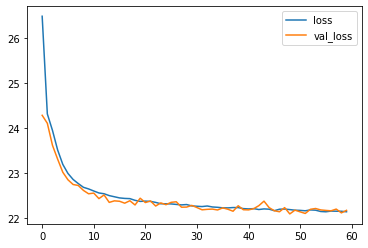

In [10]:
pd.DataFrame(history.history).plot() 


Plotting digit classes in latent space...


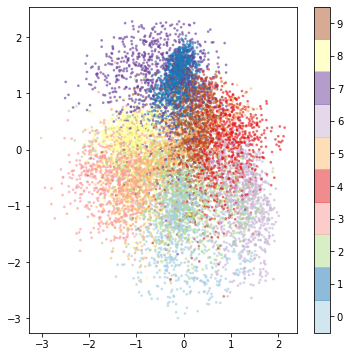

In [11]:
print("Plotting digit classes in latent space...")
#Displaying a 2D plot of the digit classes in the latent space
zTest = encoder.predict(xTest, batch_size=M)
plt.figure(figsize=(6, 6))
plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)


Plotting decoded digits...


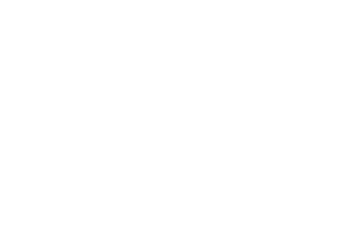

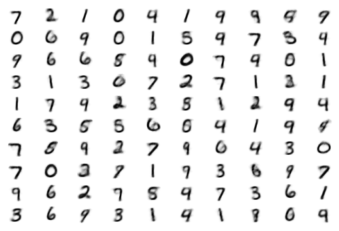

In [12]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)

xDecoded = decoder.predict(zTest)

random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, digitSize, digitSize)

#plt.figure(figsize=(50, 50))

#plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')

plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i], cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

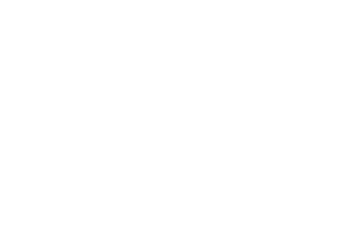

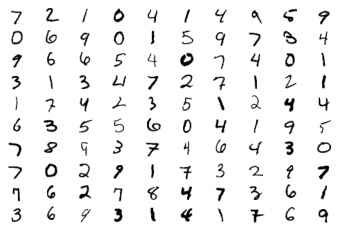

In [13]:
plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xTest[i].reshape((28,28)), cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## FREY

In [14]:
M=100

In [18]:
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(r"C:\Users\bapti\Downloads\frey_rawface.mat", squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

np.random.seed(42)
n_pixels = img_rows * img_cols
X_train = ff[:1800]
X_val = ff[1800:1900]
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), n_pixels))
X_val = X_val.reshape((len(X_val), n_pixels))

#ff = (ff.astype('float32') / 255.).reshape((len(ff), n_pixels))


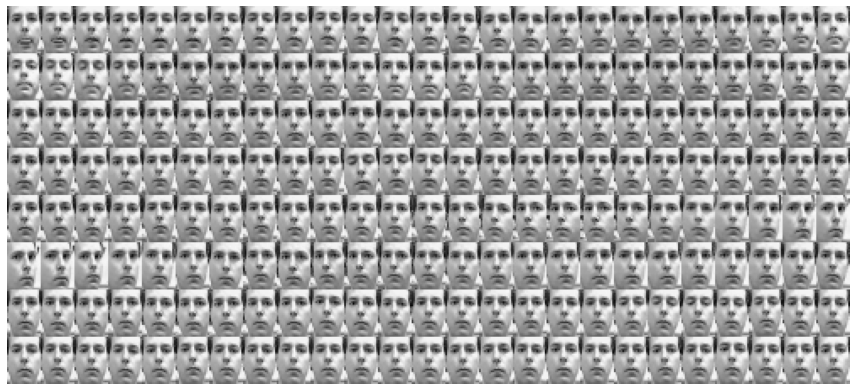

In [20]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)

In [21]:
DataDimension = 560
LatentDim = 20

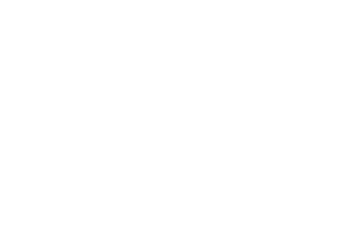

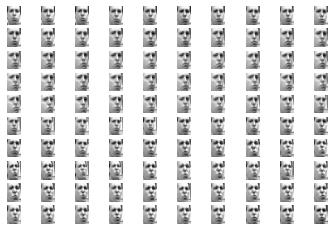

In [22]:
plt.figure()
plt.tight_layout()

plt.axis('off')
f, arr = plt.subplots(10,10)
for i in range(100):
    arr[i//10,i%10].imshow(X_val[i].reshape((28,20)), cmap='gray')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

In [23]:
IntermediateLayerDimension = 200
encoder,decoder,autoEncoder = GetBayesEncoders_gaussian(DataDimension,LatentDim,IntermediateLayerDimension, learning_rate=0.0007, rho= 0.968,momentum= 0.37)

epochs = 200
import tensorflow.keras.experimental
from keras.callbacks import LearningRateScheduler
lrs = LearningRateScheduler(tf.keras.experimental.CosineDecay(
    0.0007, 20, alpha=1e-2
))
history = autoEncoder.fit(X_train,X_train,validation_data=(X_val,X_val),shuffle=True,epochs=epochs,batch_size=M, callbacks = [lrs])

Epoch 1/200
18/18 [==============================] - 0s 16ms/step - loss: 195.8332 - val_loss: 92.3687
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 86.9019 - val_loss: 87.5461
Epoch 3/200
18/18 [==============================] - 0s 6ms/step - loss: 81.1010 - val_loss: 77.6877
Epoch 4/200
18/18 [==============================] - 0s 6ms/step - loss: 76.3424 - val_loss: 78.6256
Epoch 5/200
18/18 [==============================] - 0s 5ms/step - loss: 74.6208 - val_loss: 73.3680
Epoch 6/200
18/18 [==============================] - 0s 5ms/step - loss: 72.4983 - val_loss: 72.1606
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 71.4632 - val_loss: 71.4389
Epoch 8/200
18/18 [==============================] - 0s 4ms/step - loss: 70.1814 - val_loss: 70.9266
Epoch 9/200
18/18 [==============================] - 0s 3ms/step - loss: 69.2661 - val_loss: 69.7457
Epoch 10/200
18/18 [==============================] - 0s 2ms/step - loss: 68.5045 - val_l

18/18 [==============================] - 0s 3ms/step - loss: 65.5342 - val_loss: 66.2546
Epoch 80/200
18/18 [==============================] - 0s 2ms/step - loss: 65.5556 - val_loss: 66.2370
Epoch 81/200
18/18 [==============================] - 0s 3ms/step - loss: 65.4827 - val_loss: 66.2029
Epoch 82/200
18/18 [==============================] - 0s 2ms/step - loss: 65.5593 - val_loss: 66.1936
Epoch 83/200
18/18 [==============================] - 0s 3ms/step - loss: 65.4989 - val_loss: 66.2571
Epoch 84/200
18/18 [==============================] - 0s 2ms/step - loss: 65.4938 - val_loss: 66.2366
Epoch 85/200
18/18 [==============================] - 0s 2ms/step - loss: 65.4985 - val_loss: 66.1130
Epoch 86/200
18/18 [==============================] - 0s 3ms/step - loss: 65.4771 - val_loss: 66.2720
Epoch 87/200
18/18 [==============================] - 0s 3ms/step - loss: 65.4551 - val_loss: 66.4085
Epoch 88/200
18/18 [==============================] - 0s 3ms/step - loss: 65.4430 - val_loss: 6

Epoch 159/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9647 - val_loss: 65.9208
Epoch 160/200
18/18 [==============================] - 0s 2ms/step - loss: 64.9826 - val_loss: 65.7540
Epoch 161/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9974 - val_loss: 65.8269
Epoch 162/200
18/18 [==============================] - 0s 4ms/step - loss: 64.9797 - val_loss: 65.6379
Epoch 163/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9928 - val_loss: 65.7451
Epoch 164/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9253 - val_loss: 65.7273
Epoch 165/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9407 - val_loss: 65.7042
Epoch 166/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9556 - val_loss: 65.8947
Epoch 167/200
18/18 [==============================] - 0s 3ms/step - loss: 64.9497 - val_loss: 65.6594
Epoch 168/200
18/18 [==============================] - 0s 3ms/step - loss

In [24]:
autoEncoder.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 560)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 200)          112200      input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 20)           4020        dense_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Mul_4 (TensorFlowOp [(None, 20)]         0           dense_10[0][0]                   
_______________________________________________________________________________________

<AxesSubplot:>

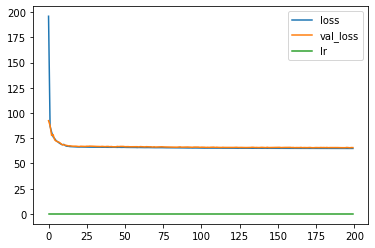

In [25]:
pd.DataFrame(history.history).plot() 


Plotting decoded digits...


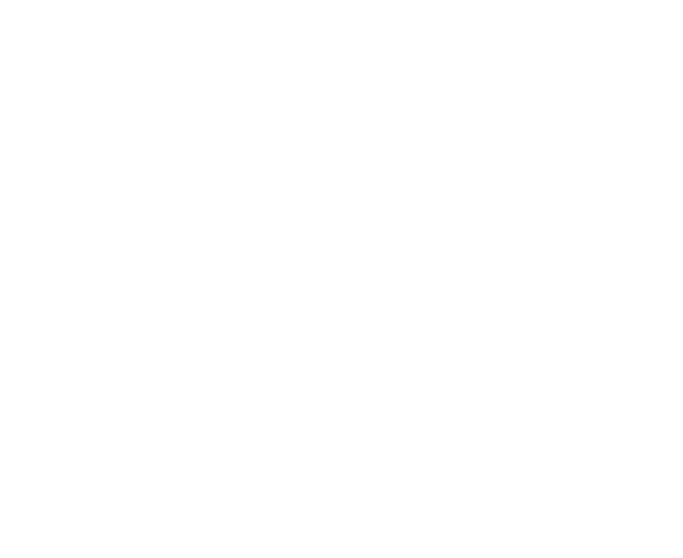

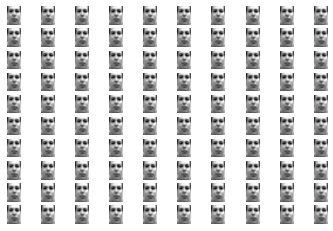

In [26]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 560
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)
zTest = encoder.predict(X_val, batch_size=M)

xDecoded = decoder.predict(zTest)

#random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, 560)


plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)
for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i].reshape((28,20)), cmap='gray')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## Other dataset : minst_corrupted \ zigzag

In [27]:
import tensorflow_datasets as tfds


img_train = tfds.as_numpy(tfds.load('mnist_corrupted/zigzag',as_supervised=False,batch_size=-1))



In [28]:
img_train=img_train["train"]["image"]

In [29]:
img_train = img_train/255

In [30]:
img_train=img_train.reshape(60000,-1)

In [31]:
DataDimension = img_train.shape[1]

In [32]:
IntermediateLayerDimension = 500
encoder,decoder,autoEncoder = GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension)

epochs = 60

history = autoEncoder.fit(img_train,img_train,shuffle=True,epochs=epochs,batch_size=M,validation_split=0.1)

Epoch 1/60
  1/540 [..............................] - ETA: 4s - loss: 74.8809WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 0.0080s). Check your callbacks.


540/540 [==============================] - 1s 2ms/step - loss: 36.7788 - val_loss: 34.2578
Epoch 2/60
540/540 [==============================] - 1s 2ms/step - loss: 33.9922 - val_loss: 33.8969
Epoch 3/60
540/540 [==============================] - 1s 2ms/step - loss: 33.7779 - val_loss: 33.7801
Epoch 4/60
540/540 [==============================] - 1s 2ms/step - loss: 33.5441 - val_loss: 33.5054
Epoch 5/60
540/540 [==============================] - 1s 2ms/step - loss: 33.2719 - val_loss: 33.1942
Epoch 6/60
540/540 [==============================] - 1s 2ms/step - loss: 32.9970 - val_loss: 32.9889
Epoch 7/60
540/540 [==============================] - 1s 2ms/step - loss: 32.7944 - val_loss: 32.8308
Epoch 8/60
540/540 [==============================] - 1s 2ms/step - loss: 32.6281 - val_loss: 32.5528
Epoch 9/60
540/540 [==============================] - 1s 2ms/step - loss: 32.4730 - val_loss: 32.4944
Epoch 10/60
540/540 [==============================] - 1s 2ms/step - loss: 32.3545 - val_loss

<AxesSubplot:>

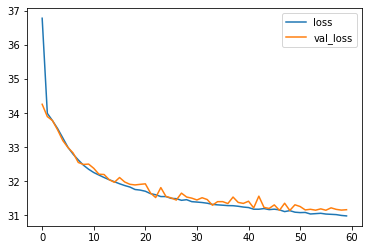

In [33]:
pd.DataFrame(history.history).plot() 

Plotting digit classes in latent space...


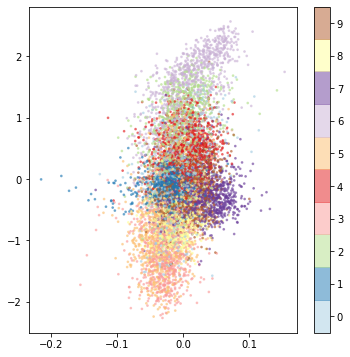

In [34]:
print("Plotting digit classes in latent space...")
#Displaying a 2D plot of the digit classes in the latent space
zTest = encoder.predict(xTest, batch_size=M)
plt.figure(figsize=(6, 6))
plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)

Plotting decoded digits...


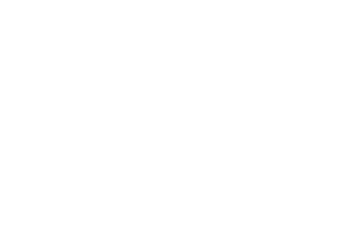

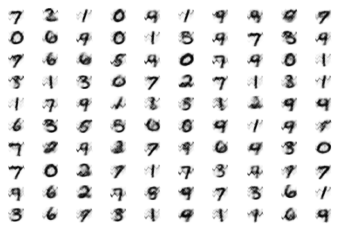

In [35]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)

xDecoded = decoder.predict(zTest)

random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, digitSize, digitSize)

#plt.figure(figsize=(50, 50))

#plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')

plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i], cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## Other dataset : minst_corrupted \ glass_blur

In [36]:
import tensorflow_datasets as tfds


img_train = tfds.as_numpy(tfds.load('mnist_corrupted/glass_blur',as_supervised=False,batch_size=-1))



In [37]:
img_train=img_train["train"]["image"]

In [38]:
img_train = img_train/255

In [39]:
img_train=img_train.reshape(60000,-1)

In [40]:
DataDimension = img_train.shape[1]

In [41]:
IntermediateLayerDimension = 500
encoder,decoder,autoEncoder = GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension)

epochs = 60

history = autoEncoder.fit(img_train,img_train,shuffle=True,epochs=epochs,batch_size=M,validation_split=0.1)

Epoch 1/60
  1/540 [..............................] - ETA: 3s - loss: 72.3336WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0070s). Check your callbacks.


539/540 [============================>.] - ETA: 0s - loss: 29.4130WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.


540/540 [==============================] - 1s 2ms/step - loss: 29.4093 - val_loss: 27.3214
Epoch 2/60
540/540 [==============================] - 1s 2ms/step - loss: 27.2325 - val_loss: 27.2149
Epoch 3/60
540/540 [==============================] - 1s 2ms/step - loss: 27.1820 - val_loss: 27.1774
Epoch 4/60
540/540 [==============================] - 1s 2ms/step - loss: 27.0981 - val_loss: 27.1451
Epoch 5/60
540/540 [==============================] - 1s 2ms/step - loss: 27.0468 - val_loss: 27.0270
Epoch 6/60
540/540 [==============================] - 1s 2ms/step - loss: 27.0019 - val_loss: 27.0457
Epoch 7/60
540/540 [==============================] - 1s 2ms/step - loss: 26.9620 - val_loss: 27.0102
Epoch 8/60
540/540 [==============================] - 1s 2ms/step - loss: 26.9358 - val_loss: 26.9695
Epoch 9/60
540/540 [==============================] - 1s 2ms/step - loss: 26.9264 - val_loss: 26.9925
Epoch 10/60
540/540 [==============================] - 1s 2ms/step - loss: 26.9102 - val_loss

<AxesSubplot:>

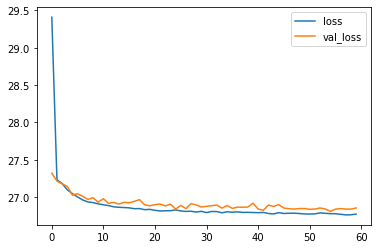

In [42]:
pd.DataFrame(history.history).plot() 

Plotting digit classes in latent space...


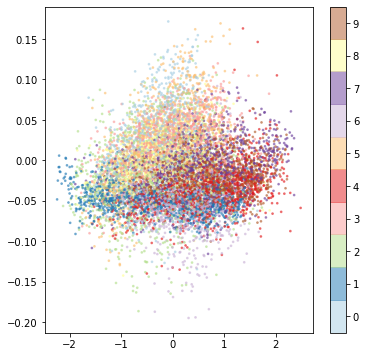

In [43]:
print("Plotting digit classes in latent space...")
#Displaying a 2D plot of the digit classes in the latent space
zTest = encoder.predict(xTest, batch_size=M)
plt.figure(figsize=(6, 6))
plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)

Plotting decoded digits...


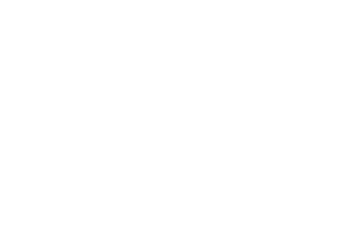

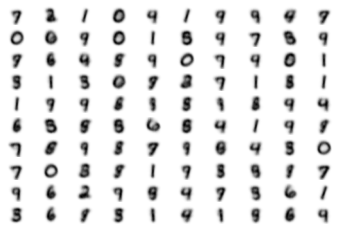

In [44]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)

xDecoded = decoder.predict(zTest)

random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, digitSize, digitSize)

#plt.figure(figsize=(50, 50))

#plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')

plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i], cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## Other dataset : minst_corrupted \ impulse

In [45]:
import tensorflow_datasets as tfds


img_train = tfds.as_numpy(tfds.load('mnist_corrupted/impulse_noise',as_supervised=False,batch_size=-1))



In [46]:
img_train=img_train["train"]["image"]

In [47]:
img_train = img_train/255

In [48]:
img_train=img_train.reshape(60000,-1)

In [49]:
DataDimension = img_train.shape[1]

In [50]:
IntermediateLayerDimension = 500
encoder,decoder,autoEncoder = GetBayesEncoders(DataDimension,LatentDim,IntermediateLayerDimension)

epochs = 60

history = autoEncoder.fit(img_train,img_train,shuffle=True,epochs=epochs,batch_size=M,validation_split=0.1)

Epoch 1/60
  1/540 [..............................] - ETA: 4s - loss: 74.8696WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 0.0080s). Check your callbacks.


540/540 [==============================] - 1s 2ms/step - loss: 45.0274 - val_loss: 43.2952
Epoch 2/60
540/540 [==============================] - 1s 2ms/step - loss: 43.2697 - val_loss: 43.2421
Epoch 3/60
540/540 [==============================] - 1s 2ms/step - loss: 43.2350 - val_loss: 43.1891
Epoch 4/60
540/540 [==============================] - 1s 2ms/step - loss: 43.2211 - val_loss: 43.1930
Epoch 5/60
540/540 [==============================] - 1s 2ms/step - loss: 43.2066 - val_loss: 43.2430
Epoch 6/60
540/540 [==============================] - 1s 2ms/step - loss: 43.1811 - val_loss: 43.1535
Epoch 7/60
540/540 [==============================] - 1s 2ms/step - loss: 43.1494 - val_loss: 43.1710
Epoch 8/60
540/540 [==============================] - 1s 2ms/step - loss: 43.1106 - val_loss: 43.0863
Epoch 9/60
540/540 [==============================] - 1s 2ms/step - loss: 43.0809 - val_loss: 43.0629
Epoch 10/60
540/540 [==============================] - 1s 2ms/step - loss: 43.0615 - val_loss

<AxesSubplot:>

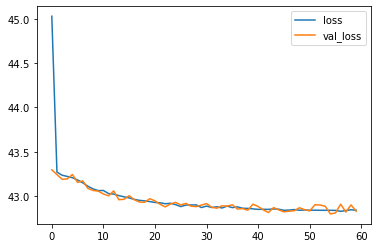

In [51]:
pd.DataFrame(history.history).plot() 

Plotting digit classes in latent space...


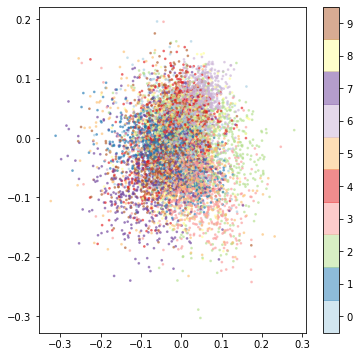

In [52]:
print("Plotting digit classes in latent space...")
#Displaying a 2D plot of the digit classes in the latent space
zTest = encoder.predict(xTest, batch_size=M)
plt.figure(figsize=(6, 6))
plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)

Plotting decoded digits...


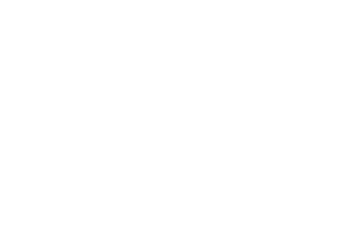

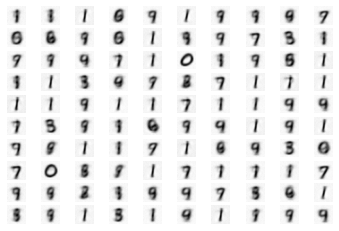

In [53]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)

xDecoded = decoder.predict(zTest)

random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, digitSize, digitSize)

#plt.figure(figsize=(50, 50))

#plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')

plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i], cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## Vanilla MINST

In [54]:
###
def GetVanillaEncoders(DataDimension,LatentDim,learning_rate=4.550835231920952e-05, rho=0.8782246913655031, momentum=0.9669845443339055):
#Vanilla decoder and decoder
    vanillaEncoder = tf.keras.models.Sequential([
    tf.keras.Input(shape=(DataDimension,)),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(LatentDim,activation="tanh")])
    
    
    vanillaDecoder = tf.keras.models.Sequential([
    tf.keras.Input(shape=(LatentDim,)),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(DataDimension,activation="tanh")])

    vanillaAutoEncoder = tf.keras.models.Sequential([vanillaEncoder,vanillaDecoder])
    #Training
    vanillaAutoEncoder.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho, momentum=momentum),
                               loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM))
    return vanillaEncoder,vanillaDecoder,vanillaAutoEncoder


lr': 4.550835231920952e-05,
 'rho': 0.8782246913655031,
 'momentum': 0.9669845443339055

In [72]:
xTrain,yTrain,xTest,yTest,DataDimension = LoadMNIST()
LatentDim = 20


In [73]:
IntermediateLayerDimension = 500
encoder2,decoder2,autoEncoder2 = GetVanillaEncoders(DataDimension,LatentDim)

epochs = 12

history = autoEncoder2.fit(xTrain,xTrain,shuffle=True,epochs=epochs,batch_size=M,validation_data=(xTest, xTest))

Epoch 1/12
  1/600 [..............................] - ETA: 4s - loss: 69.3409WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0090s). Check your callbacks.


600/600 [==============================] - 1s 2ms/step - loss: 22.1520 - val_loss: 18.5428
Epoch 2/12
600/600 [==============================] - 1s 2ms/step - loss: 16.8726 - val_loss: 15.6545
Epoch 3/12
600/600 [==============================] - 1s 2ms/step - loss: 15.2124 - val_loss: 14.6475
Epoch 4/12
600/600 [==============================] - 1s 2ms/step - loss: 14.4513 - val_loss: 13.8749
Epoch 5/12
600/600 [==============================] - 1s 2ms/step - loss: 13.7799 - val_loss: 13.5500
Epoch 6/12
600/600 [==============================] - 1s 2ms/step - loss: 13.2094 - val_loss: 12.7819
Epoch 7/12
600/600 [==============================] - 1s 2ms/step - loss: 12.7938 - val_loss: 12.7301
Epoch 8/12
600/600 [==============================] - 1s 2ms/step - loss: 12.6165 - val_loss: 12.2182
Epoch 9/12
600/600 [==============================] - 1s 2ms/step - loss: 12.5114 - val_loss: 12.0873
Epoch 10/12
600/600 [==============================] - 1s 2ms/step - loss: 12.4312 - val_loss

In [78]:
autoEncoder2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 20)                402520    
_________________________________________________________________
sequential_14 (Sequential)   (None, 784)               403284    
Total params: 805,804
Trainable params: 805,804
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

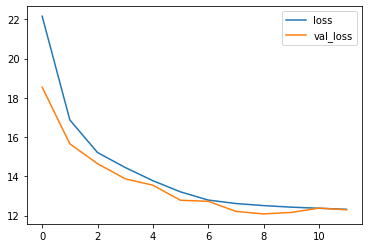

In [75]:
pd.DataFrame(history.history).plot() 


Plotting digit classes in latent space...


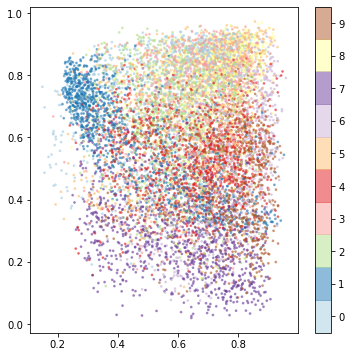

In [76]:
print("Plotting digit classes in latent space...")
#Displaying a 2D plot of the digit classes in the latent space
zTest = encoder2.predict(xTest, batch_size=M)
plt.figure(figsize=(6, 6))
plt.scatter(zTest[:, 0], zTest[:, 1], c=yTest,s=3,alpha= 0.5, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)


Plotting decoded digits...


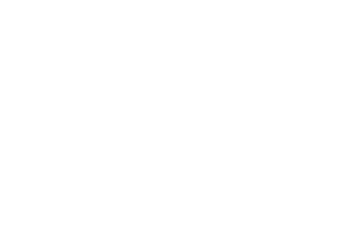

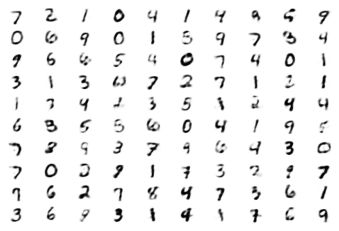

In [77]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)

xDecoded = decoder2.predict(zTest)

random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, digitSize, digitSize)

#plt.figure(figsize=(50, 50))

#plt.imshow(np.block(list(map(list, xDecoded))), cmap='binary')

plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)

for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i], cmap='binary')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

## Vanilla FREY

In [61]:
M=100

In [62]:
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(r"C:\Users\bapti\Downloads\frey_rawface.mat", squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

np.random.seed(42)
n_pixels = img_rows * img_cols
X_train = ff[:1800]
X_val = ff[1800:1900]
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), n_pixels))
X_val = X_val.reshape((len(X_val), n_pixels))




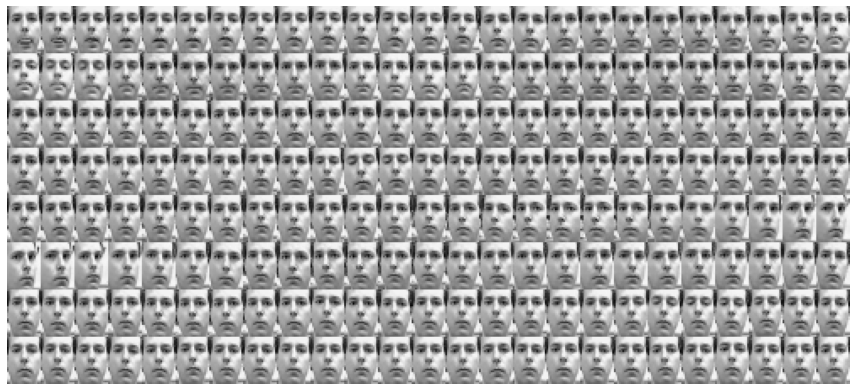

In [63]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)

In [64]:
DataDimension = 560
LatentDim = 30

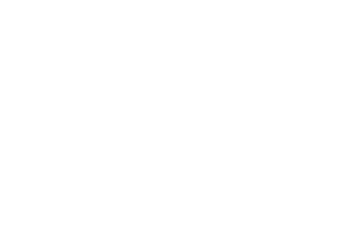

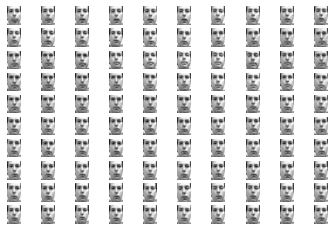

In [65]:
plt.figure()
plt.tight_layout()

plt.axis('off')
f, arr = plt.subplots(10,10)
for i in range(100):
    arr[i//10,i%10].imshow(X_train[i].reshape((28,20)), cmap='gray')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()

In [66]:
IntermediateLayerDimension = 200
encoder,decoder,autoEncoder = GetVanillaEncoders(DataDimension,LatentDim)
epochs = 2000
history = autoEncoder.fit(X_train,X_train,validation_data=(X_val,X_val),shuffle=True,epochs=epochs,batch_size=M)

Epoch 1/2000
 1/18 [>.............................] - ETA: 0s - loss: 522.2430WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.0060s). Check your callbacks.


18/18 [==============================] - 0s 12ms/step - loss: 346.8042 - val_loss: 266.1715
Epoch 2/2000
18/18 [==============================] - 0s 6ms/step - loss: 242.7921 - val_loss: 244.0850
Epoch 3/2000
18/18 [==============================] - 0s 6ms/step - loss: 219.5176 - val_loss: 217.1692
Epoch 4/2000
18/18 [==============================] - 0s 6ms/step - loss: 201.1997 - val_loss: 202.9889
Epoch 5/2000
18/18 [==============================] - 0s 3ms/step - loss: 192.5038 - val_loss: 202.3574
Epoch 6/2000
18/18 [==============================] - 0s 3ms/step - loss: 191.5515 - val_loss: 200.1142
Epoch 7/2000
18/18 [==============================] - 0s 3ms/step - loss: 187.6617 - val_loss: 193.7451
Epoch 8/2000
18/18 [==============================] - 0s 2ms/step - loss: 183.4489 - val_loss: 185.5888
Epoch 9/2000
18/18 [==============================] - 0s 2ms/step - loss: 175.7587 - val_loss: 181.2316
Epoch 10/2000
18/18 [==============================] - 0s 2ms/step - loss: 1

Epoch 80/2000
18/18 [==============================] - 0s 2ms/step - loss: 78.0714 - val_loss: 79.1796
Epoch 81/2000
18/18 [==============================] - 0s 2ms/step - loss: 74.5142 - val_loss: 73.5690
Epoch 82/2000
18/18 [==============================] - 0s 2ms/step - loss: 72.5433 - val_loss: 73.5414
Epoch 83/2000
18/18 [==============================] - 0s 2ms/step - loss: 70.3562 - val_loss: 70.8220
Epoch 84/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.8866 - val_loss: 70.6316
Epoch 85/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.8097 - val_loss: 70.4108
Epoch 86/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.6624 - val_loss: 70.2486
Epoch 87/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.5859 - val_loss: 70.4506
Epoch 88/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.5617 - val_loss: 70.2511
Epoch 89/2000
18/18 [==============================] - 0s 2ms/step - loss

Epoch 159/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1813 - val_loss: 70.3243
Epoch 160/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1931 - val_loss: 70.4198
Epoch 161/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1999 - val_loss: 70.3130
Epoch 162/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.2144 - val_loss: 70.3636
Epoch 163/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1894 - val_loss: 70.3881
Epoch 164/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1918 - val_loss: 70.3963
Epoch 165/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1922 - val_loss: 70.2221
Epoch 166/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1914 - val_loss: 70.3311
Epoch 167/2000
18/18 [==============================] - 0s 2ms/step - loss: 69.1990 - val_loss: 70.3883
Epoch 168/2000
18/18 [==============================] - 0s 2ms/s

Epoch 238/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7198 - val_loss: 69.3220
Epoch 239/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7062 - val_loss: 69.3981
Epoch 240/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7179 - val_loss: 69.3392
Epoch 241/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7056 - val_loss: 69.3373
Epoch 242/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.6946 - val_loss: 69.3193
Epoch 243/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7038 - val_loss: 69.3356
Epoch 244/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7011 - val_loss: 69.3438
Epoch 245/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.7094 - val_loss: 69.3134
Epoch 246/2000
18/18 [==============================] - 0s 2ms/step - loss: 68.6980 - val_loss: 69.3375
Epoch 247/2000
18/18 [==============================] - 0s 2ms/s

Epoch 317/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.6044 - val_loss: 65.3722
Epoch 318/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5908 - val_loss: 65.3592
Epoch 319/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5901 - val_loss: 65.3359
Epoch 320/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5829 - val_loss: 65.3477
Epoch 321/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5957 - val_loss: 65.3303
Epoch 322/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5892 - val_loss: 65.3586
Epoch 323/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5919 - val_loss: 65.4121
Epoch 324/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5930 - val_loss: 65.3359
Epoch 325/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5884 - val_loss: 65.3570
Epoch 326/2000
18/18 [==============================] - 0s 2ms/s

Epoch 396/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5112 - val_loss: 65.2875
Epoch 397/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5143 - val_loss: 65.2780
Epoch 398/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5106 - val_loss: 65.2855
Epoch 399/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5147 - val_loss: 65.3067
Epoch 400/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5056 - val_loss: 65.2802
Epoch 401/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5026 - val_loss: 65.2757
Epoch 402/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5007 - val_loss: 65.2700
Epoch 403/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5112 - val_loss: 65.2966
Epoch 404/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5033 - val_loss: 65.2986
Epoch 405/2000
18/18 [==============================] - 0s 2ms/s

Epoch 475/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4862 - val_loss: 65.2845
Epoch 476/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4928 - val_loss: 65.3077
Epoch 477/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4943 - val_loss: 65.3181
Epoch 478/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.5154 - val_loss: 65.2638
Epoch 479/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4964 - val_loss: 65.2612
Epoch 480/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4914 - val_loss: 65.2652
Epoch 481/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4929 - val_loss: 65.3116
Epoch 482/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4926 - val_loss: 65.2573
Epoch 483/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.4970 - val_loss: 65.2706
Epoch 484/2000
18/18 [==============================] - 0s 2ms/s

Epoch 554/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3806 - val_loss: 65.2134
Epoch 555/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3817 - val_loss: 65.2210
Epoch 556/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3836 - val_loss: 65.2016
Epoch 557/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3800 - val_loss: 65.1791
Epoch 558/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3761 - val_loss: 65.1962
Epoch 559/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3730 - val_loss: 65.2217
Epoch 560/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3755 - val_loss: 65.2058
Epoch 561/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3798 - val_loss: 65.1792
Epoch 562/2000
18/18 [==============================] - 0s 2ms/step - loss: 64.3823 - val_loss: 65.1833
Epoch 563/2000
18/18 [==============================] - 0s 2ms/s

Epoch 633/2000
18/18 [==============================] - 0s 3ms/step - loss: 62.9381 - val_loss: 63.6457
Epoch 634/2000
18/18 [==============================] - 0s 3ms/step - loss: 62.9280 - val_loss: 63.6708
Epoch 635/2000
18/18 [==============================] - 0s 3ms/step - loss: 62.9315 - val_loss: 63.6235
Epoch 636/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9285 - val_loss: 63.6471
Epoch 637/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9248 - val_loss: 63.6377
Epoch 638/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9243 - val_loss: 63.6179
Epoch 639/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9239 - val_loss: 63.6221
Epoch 640/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9244 - val_loss: 63.6133
Epoch 641/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.9228 - val_loss: 63.6320
Epoch 642/2000
18/18 [==============================] - 0s 2ms/s

Epoch 712/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.8311 - val_loss: 63.5097
Epoch 713/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.8162 - val_loss: 63.5318
Epoch 714/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.8111 - val_loss: 63.5197
Epoch 715/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.8081 - val_loss: 63.5050
Epoch 716/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.7959 - val_loss: 63.5291
Epoch 717/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.7973 - val_loss: 63.5091
Epoch 718/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.7971 - val_loss: 63.4835
Epoch 719/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.7980 - val_loss: 63.4924
Epoch 720/2000
18/18 [==============================] - 0s 2ms/step - loss: 62.7896 - val_loss: 63.5384
Epoch 721/2000
18/18 [==============================] - 0s 2ms/s

Epoch 791/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7144 - val_loss: 61.5195
Epoch 792/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7038 - val_loss: 61.5424
Epoch 793/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7103 - val_loss: 61.5356
Epoch 794/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7119 - val_loss: 61.5965
Epoch 795/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7255 - val_loss: 61.5378
Epoch 796/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7113 - val_loss: 61.5126
Epoch 797/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6999 - val_loss: 61.5156
Epoch 798/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6971 - val_loss: 61.5159
Epoch 799/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6964 - val_loss: 61.5188
Epoch 800/2000
18/18 [==============================] - 0s 2ms/s

Epoch 870/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6295 - val_loss: 61.4643
Epoch 871/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6311 - val_loss: 61.4290
Epoch 872/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6269 - val_loss: 61.4123
Epoch 873/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6260 - val_loss: 61.4248
Epoch 874/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6245 - val_loss: 61.4402
Epoch 875/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6238 - val_loss: 61.4410
Epoch 876/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6255 - val_loss: 61.4386
Epoch 877/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6246 - val_loss: 61.4541
Epoch 878/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6213 - val_loss: 61.4297
Epoch 879/2000
18/18 [==============================] - 0s 2ms/s

Epoch 949/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.7280 - val_loss: 61.4440
Epoch 950/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6843 - val_loss: 61.4752
Epoch 951/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6450 - val_loss: 61.4169
Epoch 952/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6277 - val_loss: 61.3763
Epoch 953/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6205 - val_loss: 61.3801
Epoch 954/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6121 - val_loss: 61.3761
Epoch 955/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6132 - val_loss: 61.4247
Epoch 956/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6145 - val_loss: 61.3812
Epoch 957/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6088 - val_loss: 61.3893
Epoch 958/2000
18/18 [==============================] - 0s 2ms/s

18/18 [==============================] - 0s 2ms/step - loss: 60.5748 - val_loss: 61.3665
Epoch 1028/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5757 - val_loss: 61.3419
Epoch 1029/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5785 - val_loss: 61.3874
Epoch 1030/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5742 - val_loss: 61.3565
Epoch 1031/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5738 - val_loss: 61.3449
Epoch 1032/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5779 - val_loss: 61.3816
Epoch 1033/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5750 - val_loss: 61.3421
Epoch 1034/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5776 - val_loss: 61.3112
Epoch 1035/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5784 - val_loss: 61.3771
Epoch 1036/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5704 - val_loss: 61.3328
Epoch 1106/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5680 - val_loss: 61.3438
Epoch 1107/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5662 - val_loss: 61.3378
Epoch 1108/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5679 - val_loss: 61.3334
Epoch 1109/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5677 - val_loss: 61.3453
Epoch 1110/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5667 - val_loss: 61.3237
Epoch 1111/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5671 - val_loss: 61.3218
Epoch 1112/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5676 - val_loss: 61.3307
Epoch 1113/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5641 - val_loss: 61.3200
Epoch 1114/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5606 - val_loss: 61.3214
Epoch 1184/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5602 - val_loss: 61.3089
Epoch 1185/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5594 - val_loss: 61.3260
Epoch 1186/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5603 - val_loss: 61.3166
Epoch 1187/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5590 - val_loss: 61.3152
Epoch 1188/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5597 - val_loss: 61.3152
Epoch 1189/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5597 - val_loss: 61.3184
Epoch 1190/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5583 - val_loss: 61.3120
Epoch 1191/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5596 - val_loss: 61.3212
Epoch 1192/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5577 - val_loss: 61.3028
Epoch 1262/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5573 - val_loss: 61.3155
Epoch 1263/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5587 - val_loss: 61.3090
Epoch 1264/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5578 - val_loss: 61.3076
Epoch 1265/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5562 - val_loss: 61.3129
Epoch 1266/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5563 - val_loss: 61.2996
Epoch 1267/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5561 - val_loss: 61.3161
Epoch 1268/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5566 - val_loss: 61.3075
Epoch 1269/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5547 - val_loss: 61.3102
Epoch 1270/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5846 - val_loss: 61.3238
Epoch 1340/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6347 - val_loss: 61.4295
Epoch 1341/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.6275 - val_loss: 61.3472
Epoch 1342/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5886 - val_loss: 61.3560
Epoch 1343/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5737 - val_loss: 61.3653
Epoch 1344/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5732 - val_loss: 61.3249
Epoch 1345/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5690 - val_loss: 61.3258
Epoch 1346/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5596 - val_loss: 61.3335
Epoch 1347/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5568 - val_loss: 61.3257
Epoch 1348/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5531 - val_loss: 61.3124
Epoch 1418/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5533 - val_loss: 61.3007
Epoch 1419/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5540 - val_loss: 61.2988
Epoch 1420/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5547 - val_loss: 61.3033
Epoch 1421/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5522 - val_loss: 61.3019
Epoch 1422/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5569 - val_loss: 61.2970
Epoch 1423/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5577 - val_loss: 61.3041
Epoch 1424/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5569 - val_loss: 61.3109
Epoch 1425/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5580 - val_loss: 61.3043
Epoch 1426/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5588 - val_loss: 61.3346
Epoch 1496/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5561 - val_loss: 61.3054
Epoch 1497/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5538 - val_loss: 61.2993
Epoch 1498/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5543 - val_loss: 61.2943
Epoch 1499/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5536 - val_loss: 61.3138
Epoch 1500/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5532 - val_loss: 61.3133
Epoch 1501/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5540 - val_loss: 61.3138
Epoch 1502/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5547 - val_loss: 61.2977
Epoch 1503/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5542 - val_loss: 61.2880
Epoch 1504/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5515 - val_loss: 61.2966
Epoch 1574/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5520 - val_loss: 61.2913
Epoch 1575/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5516 - val_loss: 61.2963
Epoch 1576/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5509 - val_loss: 61.3005
Epoch 1577/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5522 - val_loss: 61.3257
Epoch 1578/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5525 - val_loss: 61.2995
Epoch 1579/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5515 - val_loss: 61.2845
Epoch 1580/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5513 - val_loss: 61.3018
Epoch 1581/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5513 - val_loss: 61.2981
Epoch 1582/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5531 - val_loss: 61.3064
Epoch 1652/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5512 - val_loss: 61.3137
Epoch 1653/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5509 - val_loss: 61.2924
Epoch 1654/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5520 - val_loss: 61.3021
Epoch 1655/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5522 - val_loss: 61.3194
Epoch 1656/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5536 - val_loss: 61.2936
Epoch 1657/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5528 - val_loss: 61.2932
Epoch 1658/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5517 - val_loss: 61.2906
Epoch 1659/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5515 - val_loss: 61.2899
Epoch 1660/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5536 - val_loss: 61.2838
Epoch 1730/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5523 - val_loss: 61.2937
Epoch 1731/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5512 - val_loss: 61.3014
Epoch 1732/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5514 - val_loss: 61.2969
Epoch 1733/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5507 - val_loss: 61.3152
Epoch 1734/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5514 - val_loss: 61.2962
Epoch 1735/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5522 - val_loss: 61.2925
Epoch 1736/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5518 - val_loss: 61.2924
Epoch 1737/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5508 - val_loss: 61.2972
Epoch 1738/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5501 - val_loss: 61.2836
Epoch 1808/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5498 - val_loss: 61.2965
Epoch 1809/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5501 - val_loss: 61.3054
Epoch 1810/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5503 - val_loss: 61.3064
Epoch 1811/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5505 - val_loss: 61.2893
Epoch 1812/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5501 - val_loss: 61.2838
Epoch 1813/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5494 - val_loss: 61.3040
Epoch 1814/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5492 - val_loss: 61.3017
Epoch 1815/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5489 - val_loss: 61.2901
Epoch 1816/2000
18/18 [==============================] - 0s 2ms/step - 

18/18 [==============================] - 0s 2ms/step - loss: 60.5503 - val_loss: 61.2911
Epoch 1886/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5499 - val_loss: 61.2920
Epoch 1887/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5500 - val_loss: 61.2939
Epoch 1888/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5501 - val_loss: 61.2923
Epoch 1889/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5493 - val_loss: 61.2930
Epoch 1890/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5502 - val_loss: 61.2916
Epoch 1891/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5511 - val_loss: 61.2994
Epoch 1892/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5512 - val_loss: 61.2811
Epoch 1893/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5515 - val_loss: 61.2890
Epoch 1894/2000
18/18 [==============================] - 0s 3ms/step - 

18/18 [==============================] - 0s 3ms/step - loss: 60.5486 - val_loss: 61.2929
Epoch 1964/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5486 - val_loss: 61.3007
Epoch 1965/2000
18/18 [==============================] - 0s 3ms/step - loss: 60.5495 - val_loss: 61.3101
Epoch 1966/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5489 - val_loss: 61.2836
Epoch 1967/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5500 - val_loss: 61.2986
Epoch 1968/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5502 - val_loss: 61.3069
Epoch 1969/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5509 - val_loss: 61.2907
Epoch 1970/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5501 - val_loss: 61.2943
Epoch 1971/2000
18/18 [==============================] - 0s 2ms/step - loss: 60.5515 - val_loss: 61.2969
Epoch 1972/2000
18/18 [==============================] - 0s 2ms/step - 

In [67]:
autoEncoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 30)                295530    
_________________________________________________________________
sequential_8 (Sequential)    (None, 560)               296060    
Total params: 591,590
Trainable params: 591,590
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

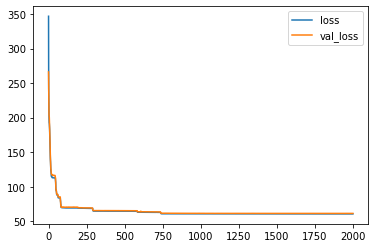

In [68]:
pd.DataFrame(history.history).plot() 


Plotting decoded digits...


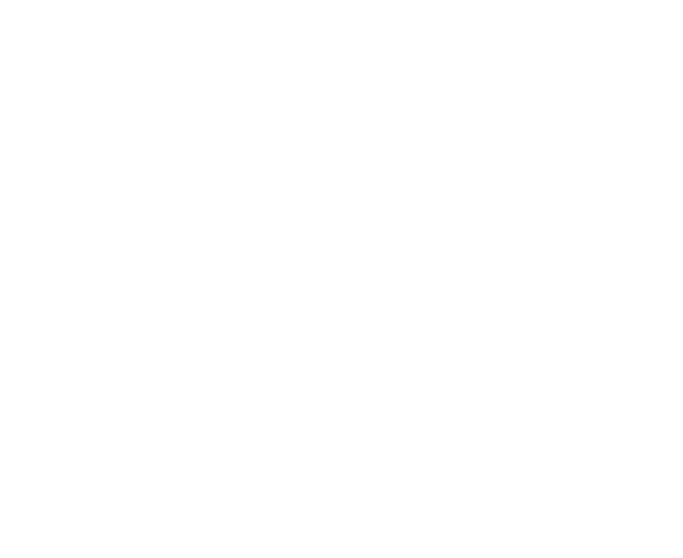

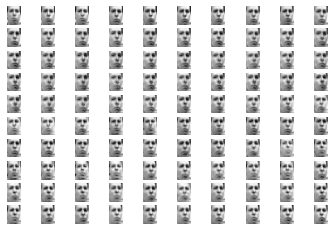

In [69]:
print("Plotting decoded digits...")
#Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digitSize = 560
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# # is Gaussian
uGrid = np.dstack(np.mgrid[0.05:n,0.05:n])/n
zGrid = norm.ppf(uGrid)
zTest = encoder.predict(X_val, batch_size=M)

xDecoded = decoder.predict(zTest)

#random_indices =  np.random.choice(zTest.shape[0], size = 100)
xDecoded = xDecoded[:100].reshape(100, 560)


plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
f, arr = plt.subplots(10,10)
for i in range(100):
    arr[i//10,i%10].imshow(xDecoded[i].reshape((28,20)), cmap='gray')
[axi.set_axis_off() for axi in arr.ravel()]
plt.show()